# Spotify Song Cluster Analysis

## Package Installations

In [1]:
!pip install nbconvert

In [2]:
!pip install latex

In [3]:
!pip install plotly.express

In [4]:
!pip install pingouin

In [5]:
import numpy as np
import pandas as pd

import re
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from pingouin import pairwise_ttests 
import statsmodels
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

## Project Overview

We used song data sourced from Spotify to assess what characteristics of a song contribute to its popularity.  With this knowledge, artists can be more intentional about the type of music they release to ensure that it is popular on spotify.  Our hypothesis being that certain audio features are more common in popular songs.  The strongest relationship we found in the data was recency, or the year the song was released, but other audio features also contributed significantly to song popularity, those features being duration, speechiness, loudness, and valence.  Since we found shorter durations and increased positivity to be contributing when songs were analyzed individually and as clusters, we would give the most attention to those features when creating a song, however all of the aforementioned were significantly associated.

## Project Background

What makes up a popular song?  We set out to analyze the components of popular songs on Spotify to see what music trends existed and how they have changed over time.  Using the information we gather, we could make predictions about how popular a song could be expected to be given its audio features.

The nature of the data took our analysis down another path, that is, to examine how popular songs were when the data for our project was sourced and look for commonalities between them in terms of audio features to determine what types of songs were most popular.  This information can still be used by artist to curate songs with characteristics similar to the most popular songs which they might be reasonably able to expect to be independently popular **and/or** become popular after being recommended to a listener by a recommendation engine given their similar audio profiles.

## Data Details 

The dataset contains a nearly 14k song subset of a Kaggle dataset sourced from Spotify's web API.  Songs in the dataset were released between 2014 and 2020 .  Spotify songs are rated for their audio features which help with create recommendations of songs a user may like based on their current selection.  These audio features are included as variables for the songs in our dataset.

**Primary:**
- **id**: Unique track id assigned by Spotify

**Numerical:**
- **acousticness**:  A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.


- **danceability**:  Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.


- **duration_ms**:  The duration of the track in milliseconds; typically ranging from 200k to 300k.



- **energy**:   Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy



- **instrumentalness**: Predicts whether a track contains no vocals.  The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.



- **liveness**:  Detects the presence of an audience in the recording.


- **loudness**:  The overall loudness of a track in decibels. Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.


- **popularity**  The popularity of the track. The value will be between 0 and 100, with 100 being the most popular.  Based on the total number of plays and how recent the plays are.


- **speechiness**:  Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording, the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.


- **tempo**:  The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.



- **valence**:  A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive, while tracks with low valence sound more negative.


- **year**:  The year the track was released

**Indicator:**
- **mode**:  Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.


- **explicit**:  Whether or not the track has explicit lyrics 


**Categorical:**
- **key**:  The key the track is in using standard Pitch Class notation.


- **artists**: Artist name


- **release_date**:  Release date of the song


- **name**:  Name of the song

### Reading Spotify in Datasets 

There were five datasets in the Kaggle dataset.

**1 - All Songs**

2 - All Songs by Artist

3 - All Songs by Genre

4 - All Songs by Year

5 - All Songs with the Genre

We decided to use the "All Songs" dataset as it offered the most expansive dataset with the most useful data.  We found that the song genres were too granular for the purposes of our analysis.

In [6]:
#Reading in spotify datasets limiting to 2014 and after where year is available
all_songs = pd.read_csv('data.csv')
all_songs = all_songs[all_songs['year'] > 2013]
all_songs.reset_index(inplace=True)
del all_songs['index']

#removing brackets from artists name's
all_songs['artists'] = all_songs['artists'].str.replace(r"\['","")
all_songs['artists'] = all_songs['artists'].str.replace(r"\']","")
all_songs.head()

valence  year  acousticness  \
0    0.591  2014        0.0489   
1    0.463  2014        0.3010   
2    0.510  2014        0.4310   
3    0.584  2014        0.0751   
4    0.211  2014        0.2200   

                                             artists  danceability  \
0                                      Ariana Grande         0.525   
1                                            J. Cole         0.692   
2                                          Vance Joy         0.484   
3                                            J. Cole         0.517   
4  Ty Dolla $ign', 'The Weeknd', 'Wiz Khalifa', '...         0.805   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       204093   0.621         0  0lizgQ7Qw35od7CYaoMBZb               0.0   
1       292987   0.521         1  62vpWI1CHwFy7tMIcSStl8               0.0   
2       204280   0.731         0  3JvrhDOgAt6p7K8mDyZwRd               0.0   
3       239320   0.705         1  6Ius4TC0L3cN74HT7ENE6e               0.0   
4       242983   0.330         1  7t2bFihaDvhIrd2gn2CWJO               0.0   

   key  liveness  loudness  mode  \
0    7    0.2940    -7.364     1   
1   10    0.0565    -8.465     0   
2    1    0.1510    -6.694     1   
3    6    0.1280    -8.205     0   
4    1    0.1050    -8.712     0   

                                                name  popularity release_date  \
0                                      Santa Tell Me          86   2014-11-24   
1                                     No Role Modelz          84   2014-12-09   
2                                            Riptide          78   2014-09-09   
3                                         Wet Dreamz          79   2014-12-09   
4  Or Nah (feat. The Weeknd, Wiz Khalifa & DJ Mus...          80   2014-06-10   

   speechiness    tempo  
0       0.1160  191.900  
1       0.3300  100.450  
2       0.0379  101.654  
3       0.3640  175.906  
4       0.1000  121.970

In [7]:
#Validating that we only have 2014 through 2020 data
all_songs['year'].unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020])

## Data Exploration & Cleaning

In [8]:
#Checking each dataframe for null values and printing descriptive statistics
print(all_songs.isna().sum())

valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64


### Descriptive Statistics

In [9]:
all_songs.describe()

valence          year  acousticness  danceability    duration_ms  \
count  13850.000000  13850.000000  13850.000000  13850.000000   13850.000000   
mean       0.450527   2017.023899      0.262342      0.629006  213673.695523   
std        0.234194      2.009061      0.285212      0.170337   61273.411870   
min        0.000000   2014.000000      0.000000      0.000000   30579.000000   
25%        0.268000   2015.000000      0.031100      0.526000  179892.500000   
50%        0.437000   2017.000000      0.144000      0.645000  208073.500000   
75%        0.620000   2019.000000      0.417750      0.753000  238133.000000   
max        0.993000   2020.000000      0.996000      0.985000  875307.000000   

             energy     explicit  instrumentalness           key  \
count  13850.000000  13850.00000      13850.000000  13850.000000   
mean       0.612610      0.35148          0.074021      5.220000   
std        0.210238      0.47745          0.226839      3.598993   
min        0.000020      0.00000          0.000000      0.000000   
25%        0.487000      0.00000          0.000000      2.000000   
50%        0.633000      0.00000          0.000001      5.000000   
75%        0.768000      1.00000          0.000424      8.000000   
max        1.000000      1.00000          1.000000     11.000000   

           liveness      loudness          mode    popularity   speechiness  \
count  13850.000000  13850.000000  13850.000000  13850.000000  13850.000000   
mean       0.182998     -7.493299      0.623321     61.178917      0.112462   
std        0.148379      4.581983      0.484571     15.819325      0.114144   
min        0.000000    -54.837000      0.000000      0.000000      0.000000   
25%        0.097300     -8.514750      0.000000     57.000000      0.039000   
50%        0.122000     -6.486500      1.000000     63.000000      0.060700   
75%        0.217000     -4.994000      1.000000     69.000000      0.141000   
max        0.987000      1.023000      1.000000    100.000000      0.918000   

              tempo  
count  13850.000000  
mean     120.725859  
std       30.588292  
min        0.000000  
25%       97.011250  
50%      120.076000  
75%      140.793500  
max      220.099000

Fortunately, our datset was pretty clean as it was.  All variables were complete with no NA or missing values.  The minimum and maximum values also fell within the expected ranges as per the documentation.

### Finding Popular Songs 

In [10]:
print('The threshold for the 75th percentile of popularirty is a popularity rating of ',all_songs.popularity.quantile(.75), 'and the threshold for the 90th percentile of popularity is a popularity rating of ', all_songs.popularity.quantile(.9))

The threshold for the 75th percentile of popularirty is a popularity rating of  69.0 and the threshold for the 90th percentile of popularity is a popularity rating of  75.0


In [11]:
all_songs[all_songs['popularity']>=69].describe()

valence         year  acousticness  danceability    duration_ms  \
count  3853.000000  3853.000000   3853.000000   3853.000000    3853.000000   
mean      0.473454  2018.257462      0.255294      0.664993  203231.753439   
std       0.226407     1.717193      0.261291      0.151925   46421.185487   
min       0.000000  2014.000000      0.000000      0.000000   57074.000000   
25%       0.298000  2017.000000      0.042100      0.573000  176547.000000   
50%       0.463000  2019.000000      0.162000      0.682000  201000.000000   
75%       0.641000  2020.000000      0.398000      0.772000  226160.000000   
max       0.980000  2020.000000      0.994000      0.980000  632625.000000   

            energy     explicit  instrumentalness         key     liveness  \
count  3853.000000  3853.000000       3853.000000  3853.00000  3853.000000   
mean      0.612346     0.413185          0.025658     5.25305     0.175399   
std       0.182644     0.492469          0.130344     3.55962     0.136232   
min       0.000020     0.000000          0.000000     0.00000     0.000000   
25%       0.500000     0.000000          0.000000     2.00000     0.096200   
50%       0.630000     0.000000          0.000000     5.00000     0.120000   
75%       0.744000     1.000000          0.000038     8.00000     0.206000   
max       1.000000     1.000000          1.000000    11.00000     0.953000   

          loudness         mode   popularity  speechiness        tempo  
count  3853.000000  3853.000000  3853.000000  3853.000000  3853.000000  
mean     -6.744038     0.593304    74.492863     0.116558   121.279041  
std       3.344613     0.491281     4.978173     0.113299    30.808471  
min     -40.449000     0.000000    69.000000     0.000000     0.000000  
25%      -7.833000     0.000000    71.000000     0.041700    97.054000  
50%      -6.146000     1.000000    73.000000     0.067600   120.001000  
75%      -4.799000     1.000000    77.000000     0.149000   142.689000  
max       0.457000     1.000000   100.000000     0.894000   220.099000

In [12]:
all_songs[all_songs['popularity']>=75].describe()

valence         year  acousticness  danceability    duration_ms  \
count  1561.000000  1561.000000   1561.000000   1561.000000    1561.000000   
mean      0.473298  2018.540038      0.248980      0.676274  200430.385010   
std       0.221702     1.643509      0.259878      0.141682   41655.686083   
min       0.000000  2014.000000      0.000010      0.000000   78681.000000   
25%       0.305000  2018.000000      0.040600      0.589000  175918.000000   
50%       0.463000  2019.000000      0.153000      0.692000  199387.000000   
75%       0.640000  2020.000000      0.388000      0.774000  221429.000000   
max       0.969000  2020.000000      0.985000      0.980000  467587.000000   

            energy     explicit  instrumentalness          key     liveness  \
count  1561.000000  1561.000000       1561.000000  1561.000000  1561.000000   
mean      0.613942     0.404228          0.016379     5.312620     0.166191   
std       0.176604     0.490899          0.099445     3.580882     0.121679   
min       0.000020     0.000000          0.000000     0.000000     0.021500   
25%       0.511000     0.000000          0.000000     2.000000     0.094900   
50%       0.632000     0.000000          0.000000     5.000000     0.119000   
75%       0.741000     1.000000          0.000024     8.000000     0.194000   
max       0.979000     1.000000          1.000000    11.000000     0.908000   

          loudness         mode   popularity  speechiness        tempo  
count  1561.000000  1561.000000  1561.000000  1561.000000  1561.000000  
mean     -6.478233     0.569507    79.338245     0.111196   121.320165  
std       2.963855     0.495304     4.191980     0.104563    30.339365  
min     -40.449000     0.000000    75.000000     0.000000     0.000000  
25%      -7.617000     0.000000    76.000000     0.042800    97.972000  
50%      -6.003000     1.000000    78.000000     0.065700   120.028000  
75%      -4.681000     1.000000    81.000000     0.137000   142.053000  
max      -1.339000     1.000000   100.000000     0.884000   207.970000

In [13]:
all_songs[all_songs['popularity']>=75].groupby('year').size()

year
2014     45
2015     77
2016     71
2017    177
2018    229
2019    351
2020    611
dtype: int64

About 28% of songs had a popularity rating at or above the 75th percentile and 11% of songs had a popularity rating in the 90th percentile.  We decided that a song would be considered popular if it scored within the 90th percentile for popularity.

# Descriptive Analysis

## Plotting Variables

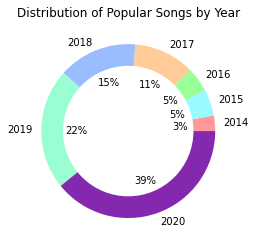

In [14]:
#Creating Donut Chart displaying distribution of popular songs by year
pie_chart = all_songs[all_songs['popularity']>=75].groupby('year').size()
labels = ['2014','2015','2016','2017','2018','2019','2020']
colors = ['#ff9999','#99faff','#99ff99','#ffcc99', '#99bdff', '#99ffd3', '#8528b0']
plt.pie(pie_chart, labels = labels, autopct='%1.f%%', colors = colors )

#Adding donut to center
circle = plt.Circle(xy=(0,0), radius=0.75, facecolor='white')
plt.gca().add_artist(circle)
plt.title('Distribution of Popular Songs by Year')
plt.show()


Nearly 40% of popular songs were released in 2020 which was not surprising since song popularity was determined in part by recency of play.  Each prior year saw a reduction in the percent contribution to popular songs for songs released in that year.

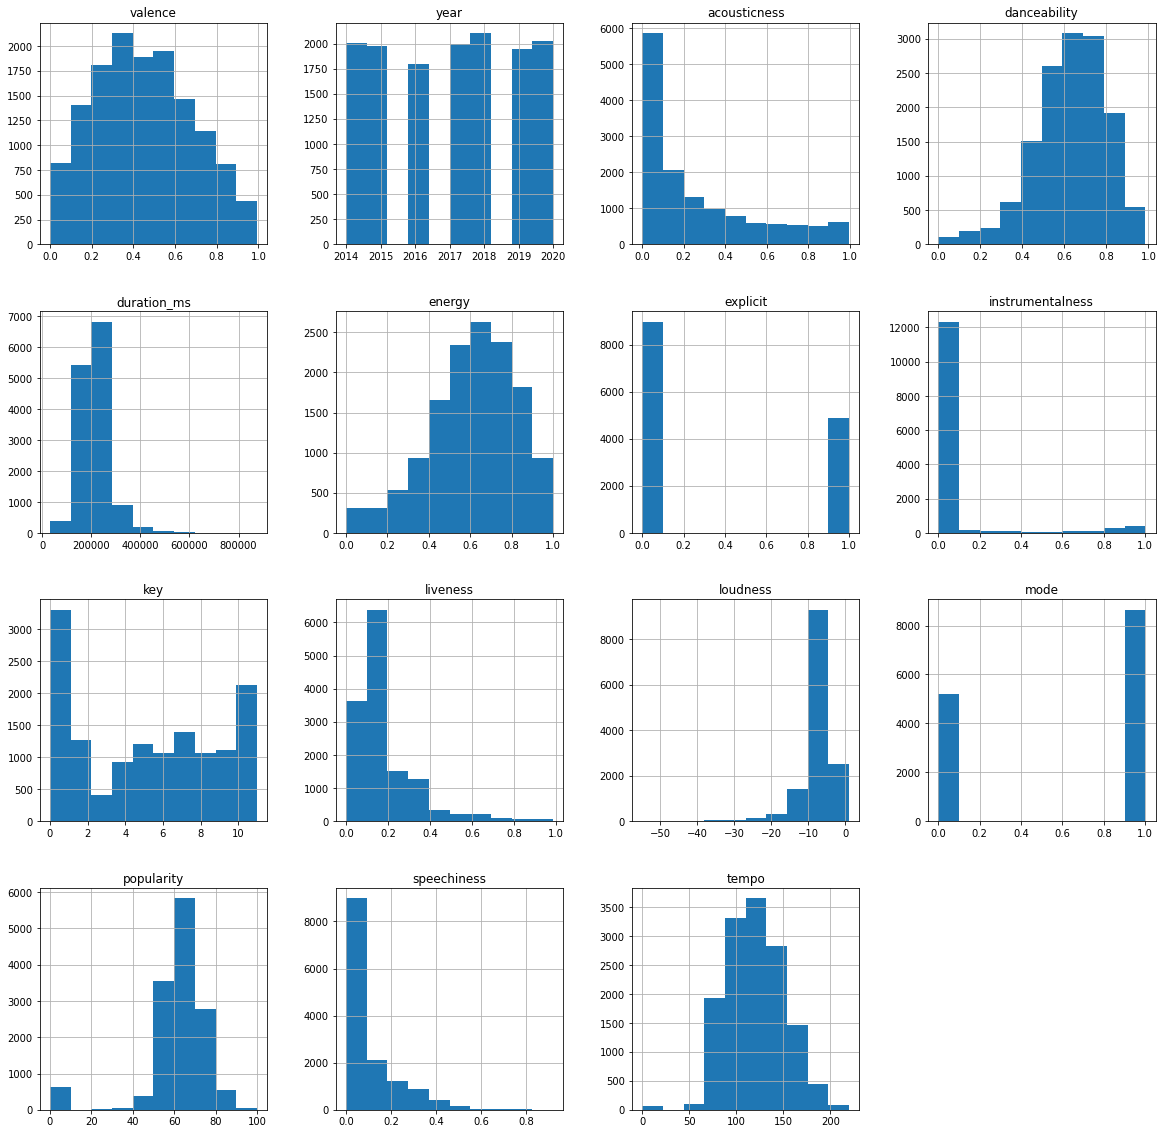

In [15]:
all_songs.hist(figsize=(20,20))
plt.show()

<font color = 'Blue'>
        
**Skewed Left**  

<br/>

<font color = 'Black'>
    
***Instrumentalness***, and to a lesser extent, ***Duration***, are almost completely distributed around the minimum value.

***Acousticness, Liveliness, and Speechiness*** have longtail distributions.

<br/>

<font color = 'Blue'>

**Skewed Right**  

<br/>

<font color = 'Black'>

***Loudness*** is skewed toward the right.

<font color = 'Blue'>

<br/>

**Normal Distribution**

<br/>

<font color = 'Black'>


***Danceability, Energy, Tempo*** and ***Valence*** are pretty normally distributed; Popularity is somewhat normally distributed.

<font color = 'Blue'>
    
<br/>    

**Indicators**

<br/>

<font color = 'Black'>

***Explicitness***, and ***Mode*** are Indicators with binary values

<br/>

<font color = 'Blue'>


**Other**

<br/>
<font color = 'Black'>

There is no clear distribution for ***Key***.

Songs to be roughly equally represented across all ***Years*** in the dataset.

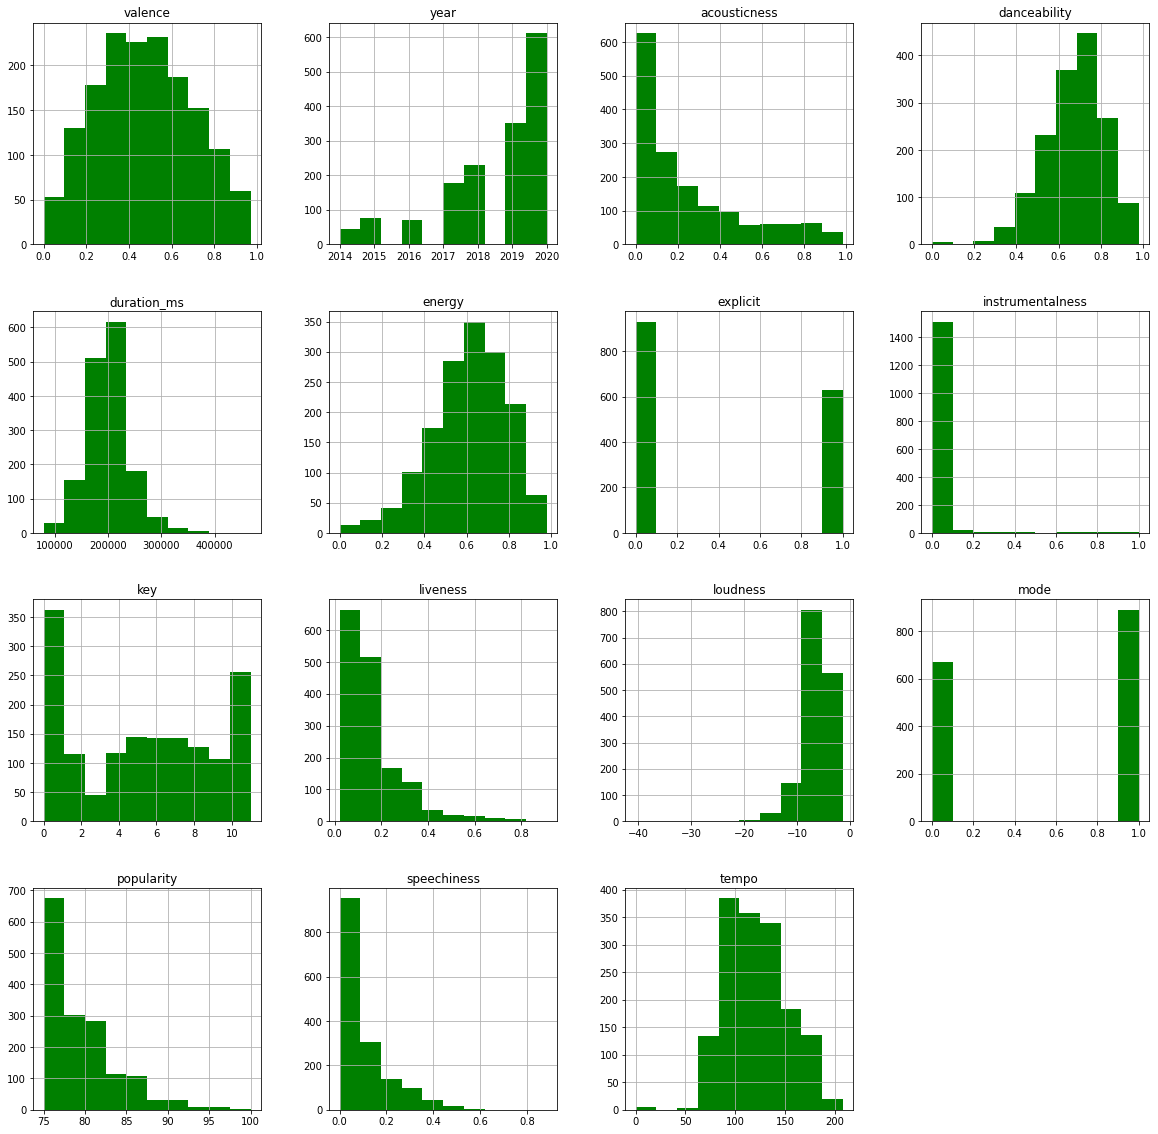

In [16]:
all_songs[all_songs['popularity']>=75].hist(figsize=(20,20), color = 'green')
plt.show()

Popular songs were similar in distribution to all songs for most variables, the most notable were that popular songs tended to be more loud, they were less likely to be live and while tempo did remain centrally distributed, there was slightly less spread.  As noted previously, popular songs also were much more likely to be released near the time the data was sourced.

## Interactions


In [17]:
#Displaying correlations for variables in the dataframe
all_songs.corr()['popularity']

valence             0.040537
year                0.212880
acousticness        0.071848
danceability        0.034076
duration_ms        -0.255084
energy             -0.110988
explicit            0.158173
instrumentalness   -0.283240
key                -0.006720
liveness           -0.046066
loudness            0.045696
mode                0.001747
popularity          1.000000
speechiness         0.035795
tempo              -0.039747
Name: popularity, dtype: float64

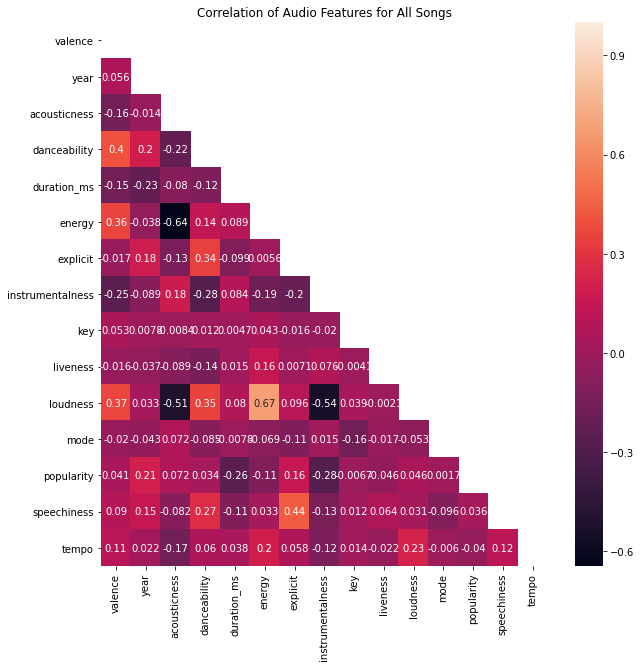

In [18]:
# Create mask for upper triangle
mask = np.triu(np.ones_like(all_songs.corr(), dtype=bool))

# Plot heat map to show correlation
plt.figure(figsize = (10,10))
sns.heatmap(all_songs.corr(), annot = True, mask=mask)
plt.title("Correlation of Audio Features for All Songs")
plt.show()

In [19]:
# Popular songs only
all_songs[all_songs['popularity']>=75].corr()['popularity']

valence             0.068596
year                0.219569
acousticness        0.012081
danceability        0.085917
duration_ms        -0.063154
energy             -0.002490
explicit            0.009833
instrumentalness   -0.026469
key                -0.000899
liveness           -0.009410
loudness            0.035037
mode               -0.040351
popularity          1.000000
speechiness         0.022743
tempo               0.004184
Name: popularity, dtype: float64

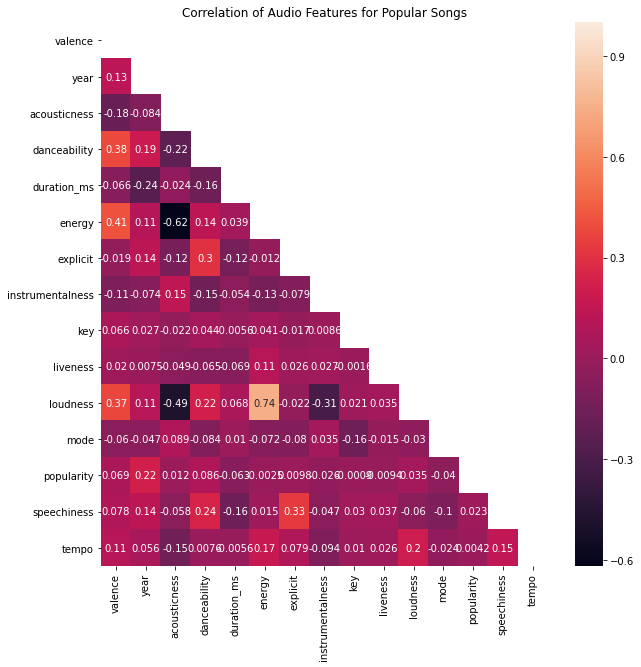

In [20]:
mask = np.triu(np.ones_like(all_songs[all_songs['popularity']>=75].corr(), dtype=bool))

# Plot heat map to show correlation
plt.figure(figsize = (10,10))
sns.heatmap(all_songs[all_songs['popularity']>=75].corr(), annot = True, mask=mask)
plt.title("Correlation of Audio Features for Popular Songs")
plt.show()

Popularity is most highly correlated with the song's year, instrumentalness and duration (a negative correlation).

For popular songs only, the features most highly correlated with popularity were increasing danceability and valence as well as decreasing duration.

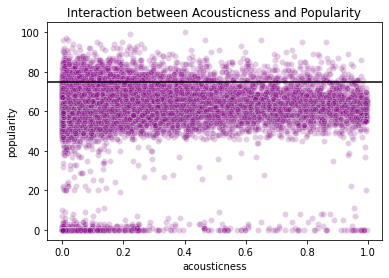

In [21]:
#Creating scatter plots for variables related to popularity
#Popular song threshold shown
sns.scatterplot(x = 'acousticness', y = 'popularity', data = all_songs, alpha = 0.2, color = 'purple')
plt.title('Interaction between Acousticness and Popularity')
plt.axhline(y=75, color = 'black')
plt.show()

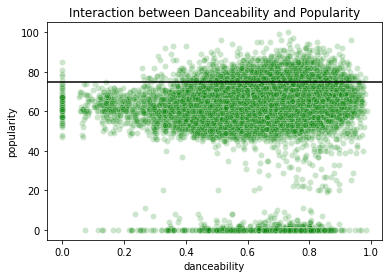

In [22]:
sns.scatterplot(x = 'danceability', y = 'popularity', data = all_songs, alpha = 0.2, color = 'green')
plt.title('Interaction between Danceability and Popularity')
plt.axhline(y=75, color = 'black')
plt.show()

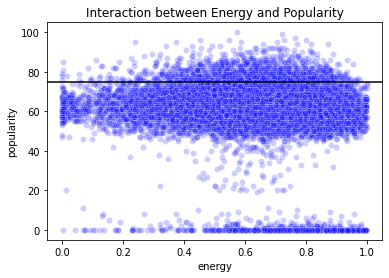

In [23]:
sns.scatterplot(x = 'energy', y = 'popularity', data = all_songs, alpha = 0.2, color = 'blue')
plt.title('Interaction between Energy and Popularity')
plt.axhline(y=75, color = 'black')
plt.show()

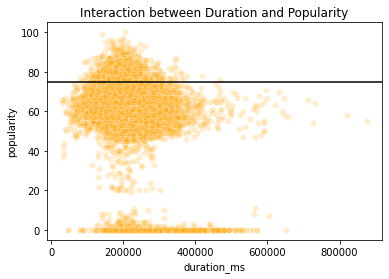

In [24]:
sns.scatterplot(x = 'duration_ms', y = 'popularity', data = all_songs, alpha = 0.2, color = 'orange')
plt.title('Interaction between Duration and Popularity')
plt.axhline(y=75, color = 'black')
plt.show()

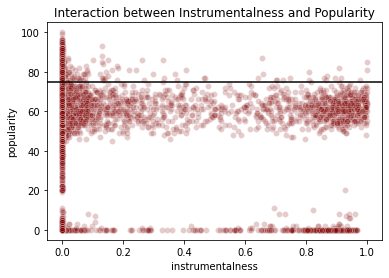

In [25]:
sns.scatterplot(x = 'instrumentalness', y = 'popularity', data = all_songs, alpha = 0.2, color = 'maroon')
plt.title('Interaction between Instrumentalness and Popularity')
plt.axhline(y=75, color = 'black')
plt.show()

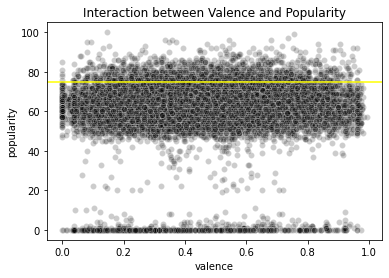

In [26]:
sns.scatterplot(x = 'valence', y = 'popularity', data = all_songs, alpha = 0.2, color = 'black')
plt.title('Interaction between Valence and Popularity')
plt.axhline(y=75, color = 'yellow')
plt.show()

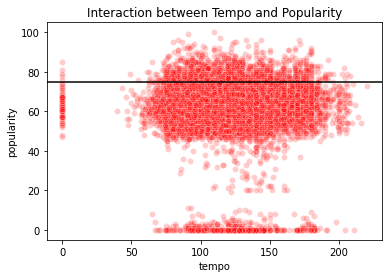

In [27]:
sns.scatterplot(x = 'tempo', y = 'popularity', data = all_songs, alpha = 0.2, color = 'red')
plt.title('Interaction between Tempo and Popularity')
plt.axhline(y=75, color = 'black')
plt.show()

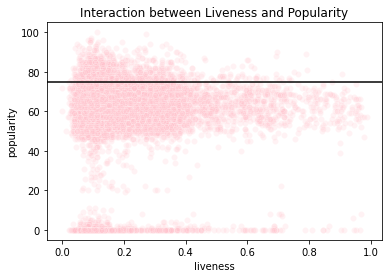

In [28]:
sns.scatterplot(x = 'liveness', y = 'popularity', data = all_songs, alpha = 0.2, color = 'pink')
plt.title('Interaction between Liveness and Popularity')
plt.axhline(y=75, color = 'black')
plt.show()

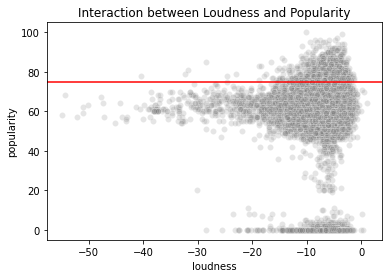

In [29]:
sns.scatterplot(x = 'loudness', y = 'popularity', data = all_songs, alpha = 0.2, color = 'gray')
plt.title('Interaction between Loudness and Popularity')
plt.axhline(y=75, color = 'red')
plt.show()

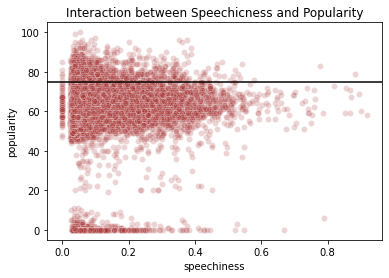

In [30]:
sns.scatterplot(x = 'speechiness', y = 'popularity', data = all_songs, alpha = 0.2, color = 'brown')
plt.title('Interaction between Speechicness and Popularity')
plt.axhline(y=75, color = 'black')
plt.show()

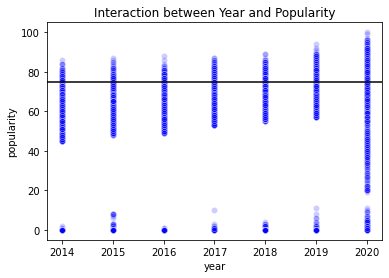

In [31]:
sns.scatterplot(x = 'year', y = 'popularity', data = all_songs, alpha = 0.2, color = 'blue')
plt.title('Interaction between Year and Popularity')
plt.axhline(y=75, color = 'black')
plt.show()

##  Takeaways

As a result of our descriptive analysis, we determined that the most important feature of a song that determined how popular it would be was the year in which the song was released.  After referencing the documentation on what contributes to the popularity score, this result was expected.  

There were some other audio features which appeared to also contribute to a songs popularity like increasing danceability where popular songs ***seemed*** to have higher scores than all songs (popular songs also seemed to have lower duration and accousticness but these were a little less clear).  

From here, we ran a cluster analysis to group songs based on their audio features to determine which of them appeared to be most important for popularity.

# Models & Statistical Analysis

## Cluster Analysis 

### Finding the Optimal Number - The Silhouette

The Silhouette method is used to measure how similar a point is to its own cluster compared to other clusters.  Using this method, we can determine the optimal number of cluster for the analysis by choosing the number of clusters that correspond to where k peaks on the Silhouette plot.

In [32]:
X = all_songs.select_dtypes(np.number)
sil = []
kmax = 20

for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k).fit(X)
    labels = kmeans.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))
    
k = [k for k in range(2,21)]
k

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [33]:
plt.plot(k,sil)
plt.title("Plotting the Silhouette")
plt.show()

In [34]:
#Creating the song clusters
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=3, 
                                   n_jobs=4))])

number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
all_songs['cluster_label'] = song_cluster_labels
all_songs['cluster_label'].unique()

array([1, 0, 2], dtype=int32)

In [35]:
#Checking descriptive stats for each cluster
all_songs[all_songs['cluster_label']==0].describe()

valence         year  acousticness  danceability    duration_ms  \
count  4820.000000  4820.000000   4820.000000   4820.000000    4820.000000   
mean      0.455847  2017.708299      0.203268      0.724194  201437.410166   
std       0.210967     1.890764      0.208991      0.130896   54017.197576   
min       0.035600  2014.000000      0.000038      0.216000   30579.000000   
25%       0.294000  2016.000000      0.038650      0.644000  167544.000000   
50%       0.445000  2018.000000      0.128000      0.741000  197707.000000   
75%       0.607000  2019.000000      0.307000      0.820000  229477.750000   
max       0.985000  2020.000000      0.992000      0.985000  727107.000000   

            energy     explicit  instrumentalness          key     liveness  \
count  4820.000000  4820.000000       4820.000000  4820.000000  4820.000000   
mean      0.613621     0.940041          0.006845     5.188797     0.185104   
std       0.143643     0.237435          0.051946     3.677049     0.142965   
min       0.156000     0.000000          0.000000     0.000000     0.022100   
25%       0.516000     1.000000          0.000000     1.000000     0.101000   
50%       0.616000     1.000000          0.000000     5.000000     0.126000   
75%       0.715000     1.000000          0.000008     8.000000     0.219000   
max       0.992000     1.000000          0.906000    11.000000     0.939000   

          loudness         mode   popularity  speechiness        tempo  \
count  4820.000000  4820.000000  4820.000000  4820.000000  4820.000000   
mean     -6.841523     0.530705    65.170124     0.195736   123.333177   
std       2.331149     0.499108     9.873095     0.141355    28.974571   
min     -20.188000     0.000000     0.000000     0.024200    39.497000   
25%      -8.108250     0.000000    60.000000     0.071600    98.223250   
50%      -6.562000     1.000000    65.000000     0.165000   124.258500   
75%      -5.247750     1.000000    71.000000     0.291000   144.018500   
max       0.457000     1.000000   100.000000     0.918000   220.099000   

       cluster_label  
count         4820.0  
mean             0.0  
std              0.0  
min              0.0  
25%              0.0  
50%              0.0  
75%              0.0  
max              0.0

In [36]:
all_songs[all_songs['cluster_label']==1].describe()

valence         year  acousticness  danceability    duration_ms  \
count  6861.000000  6861.000000   6861.000000   6861.000000    6861.000000   
mean      0.510686  2016.656464      0.161977      0.614991  223980.960939   
std       0.229039     2.017897      0.188943      0.137107   59356.525418   
min       0.033000  2014.000000      0.000002      0.099300   40000.000000   
25%       0.333000  2015.000000      0.014800      0.524000  191018.000000   
50%       0.508000  2016.000000      0.083200      0.618000  213993.000000   
75%       0.684000  2018.000000      0.251000      0.718000  241711.000000   
max       0.993000  2020.000000      0.941000      0.983000  875307.000000   

            energy     explicit  instrumentalness         key     liveness  \
count  6861.000000  6861.000000       6861.000000  6861.00000  6861.000000   
mean      0.708370     0.025069          0.055567     5.33654     0.182493   
std       0.154361     0.156347          0.189233     3.55617     0.143962   
min       0.213000     0.000000          0.000000     0.00000     0.013400   
25%       0.591000     0.000000          0.000000     2.00000     0.093400   
50%       0.718000     0.000000          0.000002     6.00000     0.124000   
75%       0.833000     0.000000          0.000460     8.00000     0.228000   
max       0.999000     1.000000          0.976000    11.00000     0.979000   

          loudness         mode   popularity  speechiness        tempo  \
count  6861.000000  6861.000000  6861.000000  6861.000000  6861.000000   
mean     -5.858665     0.651654    58.364816     0.070481   123.573610   
std       2.057640     0.476481    19.010853     0.058364    28.660508   
min     -17.473000     0.000000     0.000000     0.022600    49.452000   
25%      -7.019000     0.000000    55.000000     0.036000   100.020000   
50%      -5.632000     1.000000    62.000000     0.048900   122.053000   
75%      -4.444000     1.000000    69.000000     0.079200   142.129000   
max       1.023000     1.000000    97.000000     0.521000   210.715000   

       cluster_label  
count         6861.0  
mean             1.0  
std              0.0  
min              1.0  
25%              1.0  
50%              1.0  
75%              1.0  
max              1.0

In [37]:
all_songs[all_songs['cluster_label']==2].describe()

valence         year  acousticness  danceability    duration_ms  \
count  2169.000000  2169.000000   2169.000000   2169.000000    2169.000000   
mean      0.248410  2016.665284      0.711092      0.461810  208261.407561   
std       0.181796     1.831837      0.261686      0.197592   75171.075821   
min       0.000000  2014.000000      0.000000      0.000000   30583.000000   
25%       0.102000  2015.000000      0.597000      0.345000  162732.000000   
50%       0.221000  2017.000000      0.790000      0.484000  205000.000000   
75%       0.360000  2018.000000      0.912000      0.603000  243864.000000   
max       0.976000  2020.000000      0.996000      0.945000  820853.000000   

            energy     explicit  instrumentalness          key     liveness  \
count  2169.000000  2169.000000       2169.000000  2169.000000  2169.000000   
mean      0.307455     0.076072          0.281677     4.920701     0.179917   
std       0.197242     0.265174          0.393878     3.540772     0.172067   
min       0.000020     0.000000          0.000000     0.000000     0.000000   
25%       0.179000     0.000000          0.000001     2.000000     0.099800   
50%       0.301000     0.000000          0.001990     5.000000     0.112000   
75%       0.407000     0.000000          0.748000     8.000000     0.157000   
max       1.000000     1.000000          1.000000    11.000000     0.987000   

          loudness         mode   popularity  speechiness        tempo  \
count  2169.000000  2169.000000  2169.000000  2169.000000  2169.000000   
mean    -14.112381     0.739511    61.211157     0.060204   105.923786   
std       7.443282     0.439002    13.335946     0.065636    35.377782   
min     -54.837000     0.000000     0.000000     0.000000     0.000000   
25%     -16.232000     0.000000    58.000000     0.032900    81.446000   
50%     -11.805000     1.000000    63.000000     0.040900   104.090000   
75%      -9.176000     1.000000    67.000000     0.057400   129.980000   
max      -2.939000     1.000000    95.000000     0.789000   215.669000   

       cluster_label  
count         2169.0  
mean             2.0  
std              0.0  
min              2.0  
25%              2.0  
50%              2.0  
75%              2.0  
max              2.0

In [38]:
#Plotting the clusters
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = all_songs['name']
projection['cluster'] = all_songs['cluster_label']

fig = px.scatter(projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()

Ideally, we would have clusters that were close to each other and far from one another.  Cluster 2 is distinct from both Clusters 0 and 1 but there is a little more spread.  Clusters 0 and 1 overlap each other a little but they are tighter clusters than Cluster 2.

##  Describe Clusters 

In [39]:
all_songs.groupby('cluster_label').size()

cluster_label
0    4820
1    6861
2    2169
dtype: int64

In [40]:
#Creating Donut Chart for Song Clusters and Adding Donut to Center
cluster_all = all_songs.groupby('cluster_label').size()
cluster_labels = ['Cluster 0','Cluster 1','Cluster 2']
colors_cluster = ['#3f33a6','#d1629d','#f4f74a']
plt.pie(cluster_all, labels = cluster_labels, autopct='%1.f%%', colors = colors_cluster )


circle = plt.Circle(xy=(0,0), radius=0.75, facecolor='white')
plt.gca().add_artist(circle)
plt.title('Distribution of Songs by Cluster')
plt.show()

In [41]:
all_songs[all_songs['popularity']>=75].groupby('cluster_label').size()

cluster_label
0    695
1    701
2    165
dtype: int64

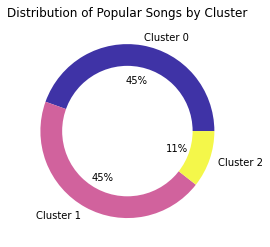

In [42]:
#Creating Donut Chart for Song Clusters Limited to Popular Songs and Adding Donut to Center
clusters_pop = all_songs[all_songs['popularity']>=75].groupby('cluster_label').size()
plt.pie(clusters_pop, labels = cluster_labels, autopct='%1.f%%', colors = colors_cluster )

circle = plt.Circle(xy=(0,0), radius=0.75, facecolor='white')
plt.gca().add_artist(circle)
plt.title('Distribution of Popular Songs by Cluster')
plt.show()

In [43]:
all_songs.groupby('cluster_label').mean()

valence         year  acousticness  danceability  \
cluster_label                                                      
0              0.455847  2017.708299      0.203268      0.724194   
1              0.510686  2016.656464      0.161977      0.614991   
2              0.248410  2016.665284      0.711092      0.461810   

                 duration_ms    energy  explicit  instrumentalness       key  \
cluster_label                                                                  
0              201437.410166  0.613621  0.940041          0.006845  5.188797   
1              223980.960939  0.708370  0.025069          0.055567  5.336540   
2              208261.407561  0.307455  0.076072          0.281677  4.920701   

               liveness   loudness      mode  popularity  speechiness  \
cluster_label                                                           
0              0.185104  -6.841523  0.530705   65.170124     0.195736   
1              0.182493  -5.858665  0.651654   58.364816     0.070481   
2              0.179917 -14.112381  0.739511   61.211157     0.060204   

                    tempo  
cluster_label              
0              123.333177  
1              123.573610  
2              105.923786

Nearly half of the songs were assigned to Cluster 1, one third to Cluster 0 and the remaining to Cluster 2.  Popular songs seem to be over-represented in Cluster 0 (+8%) and under-represented in Cluster 2 (-5%) if we were to assume they would be evenly distributed amongst all clusters.  Cluster 0 also has the highest average popularity among all clusters.  We will test to see if there is a significant difference between the popularity of songs in Cluster 0 and the other clusters.

## ANOVA Test

The Analysis of Variance (ANOVA) test is used to determine if there is a significant difference between three or more groups along some numeric value.  We will use this test to determine if popularity differs signifcantly between the song clusters as it appears to based on distributions.

**Null Hypothesis**: There is no difference in popularity between the three song clusters.


**Alternative Hypothesis**: At least one of the clusters has differs in popularity from the others.

**P-value**: 0.05/6 --> 0.0083

In [44]:
cluster_test_1 = all_songs.groupby(['cluster_label'])
cluster_names = all_songs['cluster_label'].unique()
print("\t\t\tstatistic\t\tpvalue")
for i in range(len(cluster_names)):
    for j in range(i+1, len(cluster_names)):
        cluster1 = cluster_test_1[['popularity']].get_group(cluster_names[i])
        cluster2 = cluster_test_1[['popularity']].get_group(cluster_names[j])
        stat, pvalue = stats.ttest_ind(cluster1, cluster2, equal_var = False)
        print('Cluster ' + str(cluster_names[i]) + " vs. " + 'Cluster ' +  str(cluster_names[j]) + "\t" + str(stat[0]) + "\t" + str(pvalue[0]))

			statistic		pvalue
Cluster 1 vs. Cluster 0	-25.2048452417058	2.7928748161960004e-136
Cluster 1 vs. Cluster 2	-7.75620300747291	1.04692635454707e-14
Cluster 0 vs. Cluster 2	12.382733855200533	1.88577246956435e-34


In [45]:
#Finding Correlations to determine which characteristics of Cluster 0 Might Contribute to Popularity
all_songs[all_songs['cluster_label']==0].corr()['popularity']

valence             0.049856
year                0.370702
acousticness        0.028634
danceability        0.022490
duration_ms        -0.108151
energy             -0.010146
explicit           -0.018221
instrumentalness   -0.021723
key                 0.001024
liveness           -0.052745
loudness            0.082234
mode               -0.003545
popularity          1.000000
speechiness        -0.108464
tempo               0.018844
cluster_label            NaN
Name: popularity, dtype: float64

In [46]:
clusters_pct = round((pd.crosstab(all_songs['cluster_label'], all_songs['year'], normalize='index')*100),1)
clusters_pct

year           2014  2015  2016  2017  2018  2019  2020
cluster_label                                          
0               7.2   9.5  10.6  13.8  18.8  17.0  23.0
1              19.4  17.0  13.7  13.1  13.4  12.2  11.2
2              15.2  16.1  16.0  19.7  12.6  13.4   7.0

Cluster 0 has many almost twice as many songs released in 2020 as other years.  We will want to focus on other audio features that might impact song popularity.  The next five most highly correlated features were **duration_ms**(-), **speechiness**(-), **loudness**(+), **liveness**(-), **valence**(+).

In [47]:
cluster_test_2 = all_songs.groupby(['cluster_label'])
print('Testing for significant differences in duration')
print("\t\t\tstatistic\t\tpvalue")
for i in range(len(cluster_names)):
    for j in range(i+1, len(cluster_names)):
        cluster1 = cluster_test_1[['duration_ms']].get_group(cluster_names[i])
        cluster2 = cluster_test_1[['duration_ms']].get_group(cluster_names[j])
        stat, pvalue = stats.ttest_ind(cluster1, cluster2, equal_var = False)
        print('Cluster ' + str(cluster_names[i]) + " vs. " + 'Cluster ' +  str(cluster_names[j]) + "\t" + str(stat[0]) + "\t" + str(pvalue[0]))

Testing for significant differences in duration
			statistic		pvalue
Cluster 1 vs. Cluster 0	21.31235601173303	8.766142753199607e-99
Cluster 1 vs. Cluster 2	8.901276167879514	9.243469903282425e-19
Cluster 0 vs. Cluster 2	-3.8084457455415484	0.0001424561521290885


In [48]:
cluster_test_3 = all_songs.groupby(['cluster_label'])
print('Testing for significant differences in speechiness')
print("\t\t\tstatistic\t\tpvalue")
for i in range(len(cluster_names)):
    for j in range(i+1, len(cluster_names)):
        cluster1 = cluster_test_1[['speechiness']].get_group(cluster_names[i])
        cluster2 = cluster_test_1[['speechiness']].get_group(cluster_names[j])
        stat, pvalue = stats.ttest_ind(cluster1, cluster2, equal_var = False)
        print('Cluster ' + str(cluster_names[i]) + " vs. " + 'Cluster ' +  str(cluster_names[j]) + "\t" + str(stat[0]) + "\t" + str(pvalue[0]))

Testing for significant differences in speechiness
			statistic		pvalue
Cluster 1 vs. Cluster 0	-58.135942527149545	0.0
Cluster 1 vs. Cluster 2	6.522311953008018	7.974305966795685e-11
Cluster 0 vs. Cluster 2	54.73339916738918	0.0


In [49]:
cluster_test_4 = all_songs.groupby(['cluster_label'])
print('Testing for significant differences in loudness')
print("\t\t\tstatistic\t\tpvalue")
for i in range(len(cluster_names)):
    for j in range(i+1, len(cluster_names)):
        cluster1 = cluster_test_1[['loudness']].get_group(cluster_names[i])
        cluster2 = cluster_test_1[['loudness']].get_group(cluster_names[j])
        stat, pvalue = stats.ttest_ind(cluster1, cluster2, equal_var = False)
        print('Cluster ' + str(cluster_names[i]) + " vs. " + 'Cluster ' +  str(cluster_names[j]) + "\t" + str(stat[0]) + "\t" + str(pvalue[0]))

Testing for significant differences in loudness
			statistic		pvalue
Cluster 1 vs. Cluster 0	23.5315961986612	4.596941478476075e-119
Cluster 1 vs. Cluster 2	51.030653597128776	0.0
Cluster 0 vs. Cluster 2	44.521705128832295	7.496382956e-315


In [50]:
cluster_test_5 = all_songs.groupby(['cluster_label'])
print('Testing for significant differences in liveness')
print("\t\t\tstatistic\t\tpvalue")
for i in range(len(cluster_names)):
    for j in range(i+1, len(cluster_names)):
        cluster1 = cluster_test_1[['liveness']].get_group(cluster_names[i])
        cluster2 = cluster_test_1[['liveness']].get_group(cluster_names[j])
        stat, pvalue = stats.ttest_ind(cluster1, cluster2, equal_var = False)
        print('Cluster ' + str(cluster_names[i]) + " vs. " + 'Cluster ' +  str(cluster_names[j]) + "\t" + str(stat[0]) + "\t" + str(pvalue[0]))

Testing for significant differences in liveness
			statistic		pvalue
Cluster 1 vs. Cluster 0	-0.9687312719552021	0.3327017766891185
Cluster 1 vs. Cluster 2	0.6311524524674923	0.5279861452611969
Cluster 0 vs. Cluster 2	1.226412139393558	0.22012451984013937


In [51]:
cluster_test_6 = all_songs.groupby(['cluster_label'])
print('Testing for significant differences in valence')
print("\t\t\tstatistic\t\tpvalue")
for i in range(len(cluster_names)):
    for j in range(i+1, len(cluster_names)):
        cluster1 = cluster_test_1[['valence']].get_group(cluster_names[i])
        cluster2 = cluster_test_1[['valence']].get_group(cluster_names[j])
        stat, pvalue = stats.ttest_ind(cluster1, cluster2, equal_var = False)
        print('Cluster ' + str(cluster_names[i]) + " vs. " + 'Cluster ' +  str(cluster_names[j]) + "\t" + str(stat[0]) + "\t" + str(pvalue[0]))

Testing for significant differences in valence
			statistic		pvalue
Cluster 1 vs. Cluster 0	13.347726057953212	2.5349391973686756e-40
Cluster 1 vs. Cluster 2	54.827546428093044	0.0
Cluster 0 vs. Cluster 2	41.93321064951664	0.0


The results of the ANOVA test allow us to reject the hypothesis that there is no difference in the average popularity, duration, speechiness, loudness, and valence among the groups.  We fail to reject a difference among the groups in liveness.

# Conclusions & Recommendations

As a result of our analysis, we found that the audio features that had the highest impact on a song's popularity were the songs danceability and positivity/valence; where increased ratings led to higher popularity ratings.  Additionally song duration was negatively correlated as people seemed to prefer shorter songs.  Our recommendation would be to release a danceable song with a positive message but it should be a little shorter of a song.

For artists looking to increase exposure, or gain popularity, through recommendations on the platform, we recommend making songs that have similar make-ups to Cluster 0.  These songs have a good mix of words and music but leaning toward more music (average rating 0.2 , lowest among clusters), are on the louder side (average loudness -6.8), are moderately positive (average valence 0.5) and are on the shorter side (average duration less than 3.5 minutes which was lowest among the clusters).  These were the audio features that were most highly correlated with popularity.

In [52]:
round((all_songs.groupby('cluster_label')['duration_ms'].mean()/60000),1)

cluster_label
0    3.4
1    3.7
2    3.5
Name: duration_ms, dtype: float64

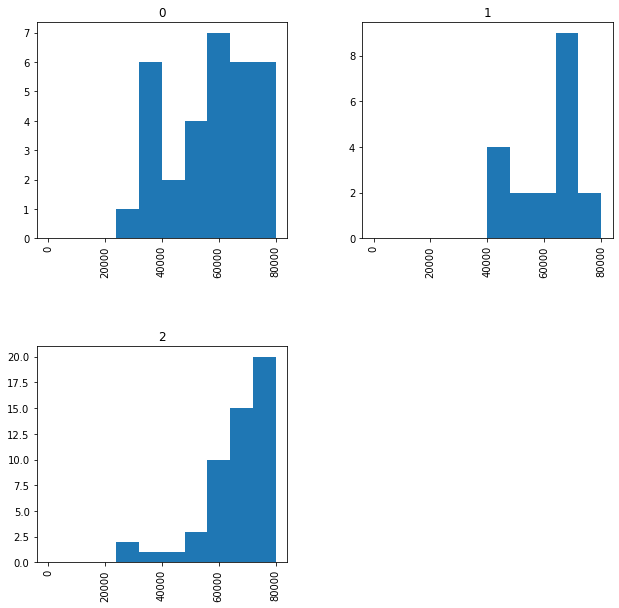

In [53]:
all_songs['duration_ms'].hist(by=all_songs['cluster_label'], figsize=(10,10), range=(0,80000))
plt.show()

In [54]:
all_songs.groupby('cluster_label')['speechiness'].mean()

cluster_label
0    0.195736
1    0.070481
2    0.060204
Name: speechiness, dtype: float64

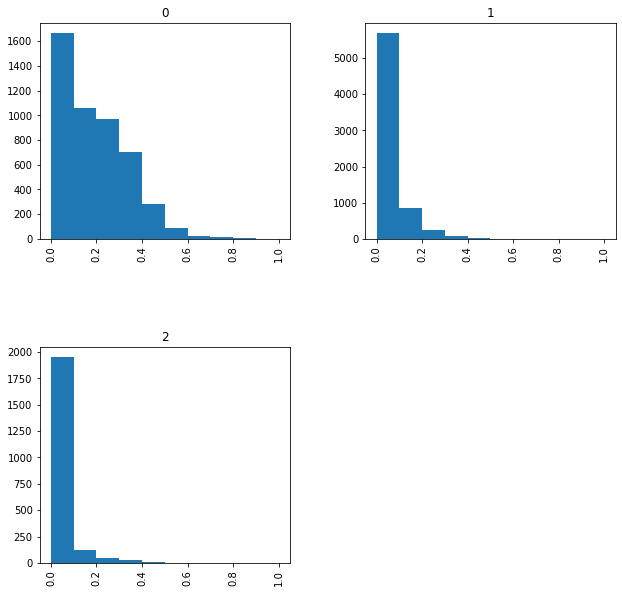

In [55]:
all_songs['speechiness'].hist(by=all_songs['cluster_label'], figsize=(10,10), range=(0,1))
plt.show()

In [56]:
all_songs.groupby('cluster_label')['loudness'].mean()

cluster_label
0    -6.841523
1    -5.858665
2   -14.112381
Name: loudness, dtype: float64

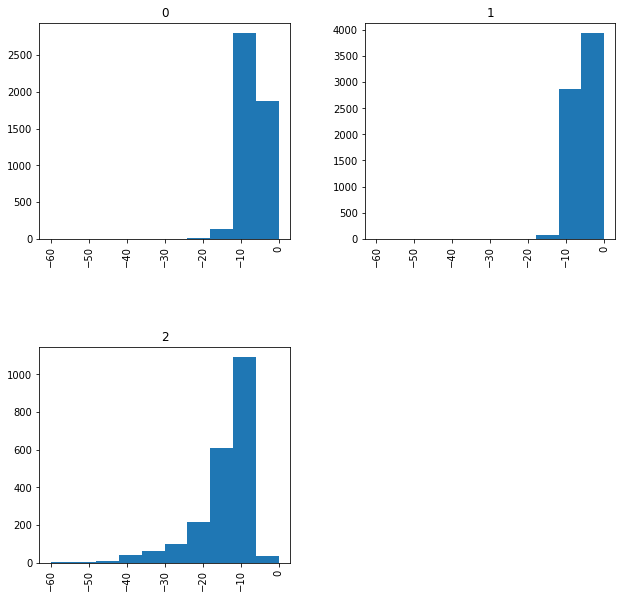

In [57]:
all_songs['loudness'].hist(by=all_songs['cluster_label'], figsize=(10,10), range=(-60,0))
plt.show()

In [58]:
all_songs.groupby('cluster_label')['valence'].mean()

cluster_label
0    0.455847
1    0.510686
2    0.248410
Name: valence, dtype: float64

In [59]:
all_songs['valence'].hist(by=all_songs['cluster_label'], figsize=(10,10), range = (0,1))
plt.show()

# References 

[Amplifying Artist Input in Your Personalized Recommendations](https://newsroom.spotify.com/2020-11-02/amplifying-artist-input-in-your-personalized-recommendations/) - Reference information on how to increase exposure with Spotify's recommendation system.

[Spotify dataset](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks) - Source dataset for analysis.

[Spotify Web API Resources](https://developer.spotify.com/documentation/web-api/reference/) - Reference documentation on audio features and Spotify's web API.

[The Silhouette Method](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb#:~:text=The%20Elbow%20Method%20is%20more,for%20finding%20the%20optimal%20K.) - Background information on K-means cluster analysis and the Silhouette method.


In [61]:
!jupyter nbconvert --to pdf Song_Cluster_Analysis.ipynb

[NbConvertApp] Converting notebook Song_Cluster_Analysis.ipynb to pdf
/opt/conda/lib/python3.6/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['text/html']) is not able to be represented.
  mimetypes=output.keys())
/opt/conda/lib/python3.6/site-packages/nbconvert/filters/datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.plotly.v1+json', 'text/html']) is not able to be represented.
  mimetypes=output.keys())
[NbConvertApp] Support files will be in Song_Cluster_Analysis_files/
[NbConvertApp] Making directory Song_Cluster_Analysis_files
[NbConvertApp] Making directory Song_Cluster_Analysis_files
[NbConvertApp] Making directory Song_Cluster_Analysis_files
[NbConvertApp] Making directory Song_Cluster_Analysis_files
[NbConvertApp] Making directory Song_Cluster_Analysis_files
[NbConvertApp] Making directory Song_Cluster_Analysis_files
[NbConvertApp] Making directory Song_Cluster_Analysis_fil